## Priori Balancing Notebook
---

In this notebook we will focus on priori data balancing. This means that we focus on the raw audio data and try to balance the classes by cutting audios, removing outliers and augmenting the data.

1. [Load Data](#Load-Data)
2. [Data Distribution](#Data-Distribution)
3. [Data Balancing](#Data-Balancing) ([Cutting Audios](#Cutting-Audios) - [Removing Outliers](#Removing-Outliers) - [Augmenting Data](#Augmenting-Data))

[Shorten window](#Shorten-window)

In [14]:
# import all the functions
from utils import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Audio
import random
import shutil

#### 1. Load Data <a id='Load-Data'></a>

In [15]:
# paths to the features and the labels
FEATURES_RAW_DIR = '../features/raw/'

BASE_DIR = "../dataset/"
OUTLIERS_DIR = BASE_DIR + 'outliers/'
ARTIFACTS_DIR = BASE_DIR + 'artifacts/'
EXTRAHLS_DIR = BASE_DIR + 'extrahls/'
MURMURS_DIR = BASE_DIR + 'murmurs/'
NORMALS_DIR = BASE_DIR + 'normals/'
EXTRASTOLES_DIR = BASE_DIR + 'extrastoles/'
DIRS = [ARTIFACTS_DIR, EXTRAHLS_DIR, MURMURS_DIR, NORMALS_DIR, EXTRASTOLES_DIR]
#SAMPLE_RATE = 22050

metadata = pd.read_csv(BASE_DIR + "/metadata.csv")
annotation = pd.read_csv(BASE_DIR + "/annotation.csv")
lables = pd.read_csv(BASE_DIR + "/labels.csv")

audio_info= pd.merge(metadata, lables, on='filename')

sns.set_theme(context="paper", font_scale=1)

#### 2. Data Distribution <a id='Data-Distribution'></a>

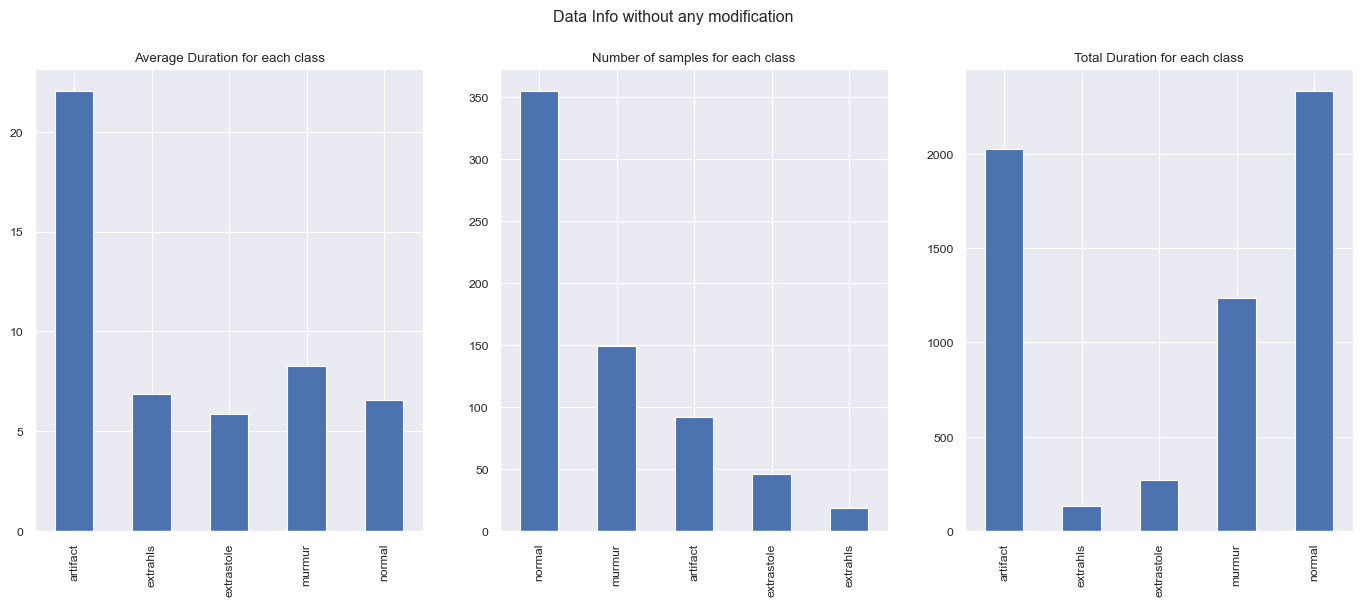

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(17, 6))
fig.suptitle('Data Info without any modification')

# avg duraton for each class
audio_info.groupby('label')['duration'].mean().plot.bar(ax = axs[0], title='Average Duration for each class')
_ = axs[0].set_xlabel('')

# number of samples for each class
audio_info['label'].value_counts().plot.bar(ax = axs[1], title='Number of samples for each class')
_ = axs[1].set_xlabel('')

# total duration for each class
audio_info.groupby('label')['duration'].sum().plot.bar(ax = axs[2], title='Total Duration for each class')
_ = axs[2].set_xlabel('')

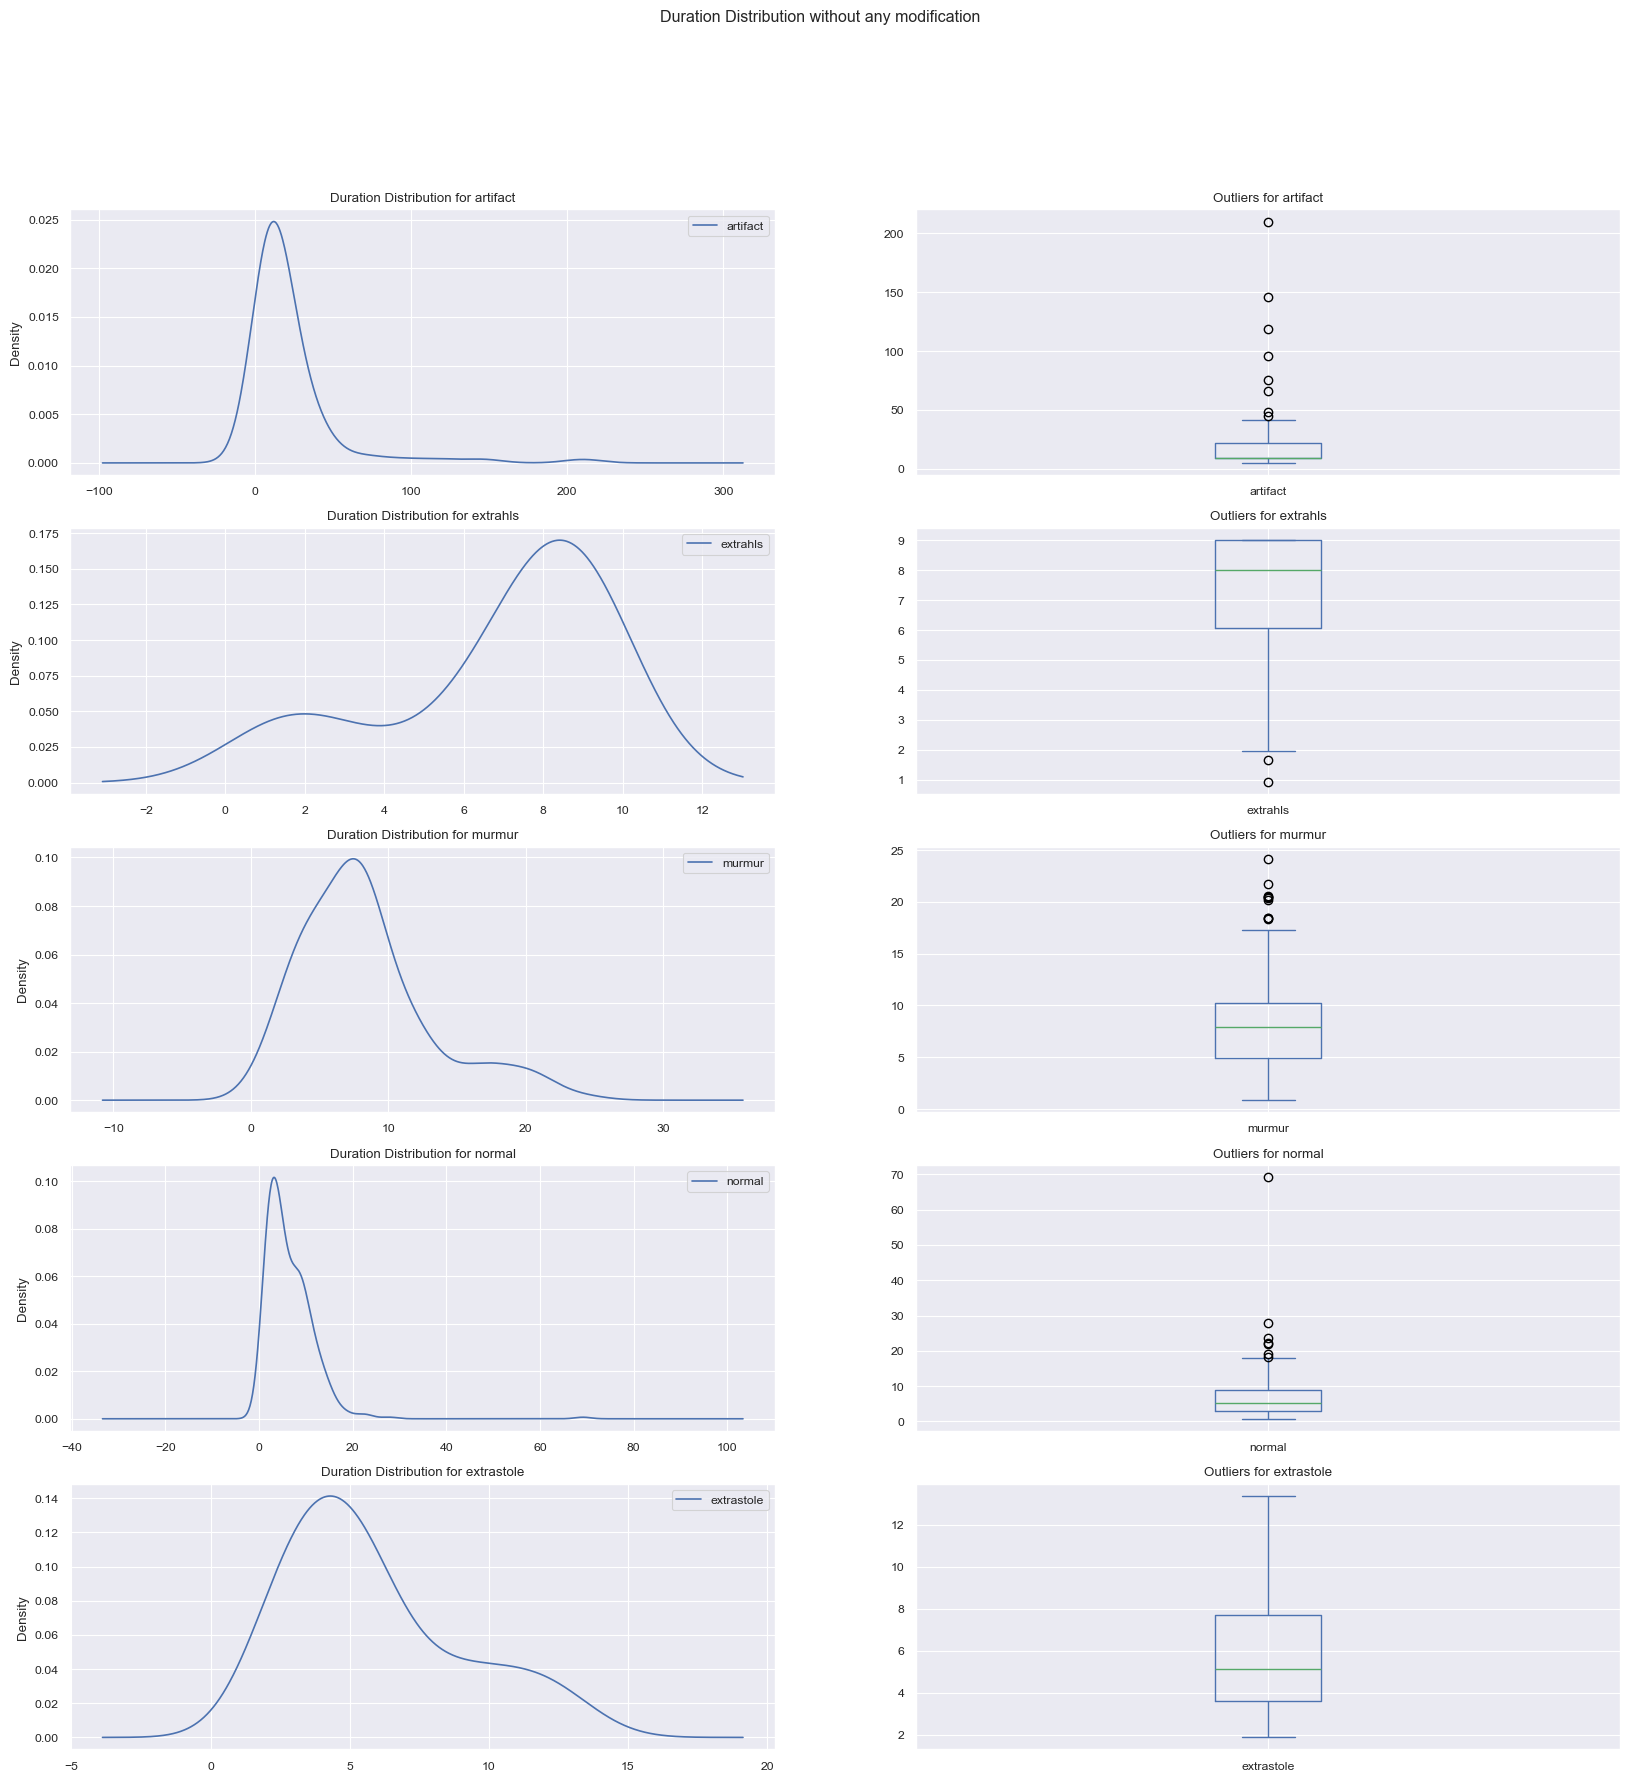

In [17]:
# duration distribution
names = audio_info['label'].unique()
fig, axs = plt.subplots(len(names), 2, figsize=(20, 20))
fig.suptitle('Duration Distribution without any modification')

for i, name in enumerate(names):
	audio_info[audio_info['label']== name].groupby('label')['duration'].plot(legend=True, title=f'Duration Distribution for {name}', kind='kde', ax = axs[i][0])
	audio_info[audio_info['label']== name].groupby('label')['duration'].plot(legend=True, title=f'Outliers for {name}', kind='box', ax = axs[i][1])

#### 3. Data Balancing <a id='Data-Balancing'></a>

##### 3.1 Cutting Audios <a id='Cutting-Audios'></a>

##### 3.2 Removing Outliers <a id='Removing-Outliers'></a>

In [18]:
# Calculate the quantiles for each label
Q1 = audio_info.groupby('label')['duration'].apply(lambda x: x.quantile(0.25))
Q3 = audio_info.groupby('label')['duration'].apply(lambda x: x.quantile(0.75))

# Calculate the IQR for each label
IQR = Q3 - Q1

# Find the outliers for each label using IQR
outliers = audio_info.groupby('label').apply(lambda x: x[(x['duration'] < (Q1[x.name] - 1.5 * IQR[x.name])) | (x['duration'] > (Q3[x.name] + 1.5 * IQR[x.name]))])

In [19]:
classname = 'artifact'
src_dir = ARTIFACTS_DIR

# get the outliers for the artifact class
out = get_move_outliers(src_dir = src_dir, out_dir=OUTLIERS_DIR, classname = classname, outliers=outliers, audio_info=audio_info, move=False)
# drop the outliers for {classname}
audio_info_outliers = audio_info[~audio_info['filename'].isin(out)]

artifact outliers ['artifact_2023_7.wav', 'artifact_2023_8.wav', 'artifact_2023_9.wav', 'artifact_2023_29.wav', 'artifact_2023_47.wav', 'artifact_2023_49.wav', 'artifact_2023_50.wav', 'artifact_2023_51.wav']
number of artifact outliers 8
directory size 84


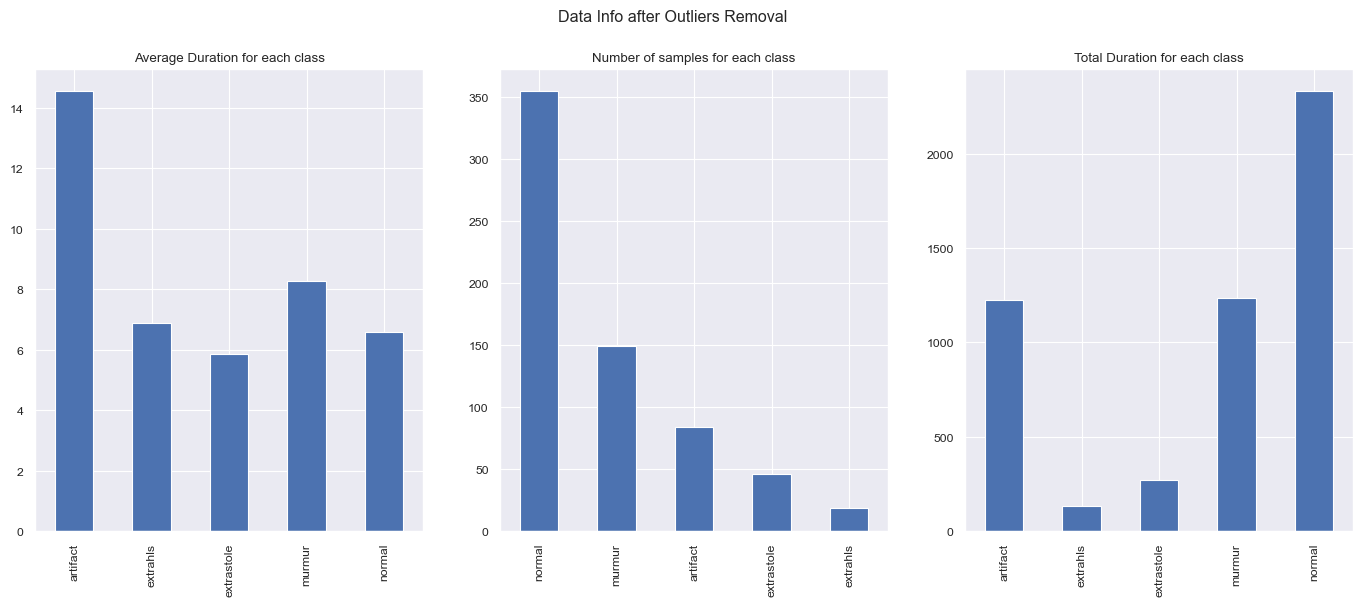

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(17, 6))
fig.suptitle('Data Info after Outliers Removal')

# avg duraton for each class
audio_info_outliers.groupby('label')['duration'].mean().plot.bar(ax = axs[0], title='Average Duration for each class')
avg_duration = audio_info_outliers.groupby('label')['duration'].mean()
_ = axs[0].set_xlabel('')

# number of samples for each class
audio_info_outliers['label'].value_counts().plot.bar(ax = axs[1], title='Number of samples for each class')
_ = axs[1].set_xlabel('')

# total duration for each class
audio_info_outliers.groupby('label')['duration'].sum().plot.bar(ax = axs[2], title='Total Duration for each class')
_ = axs[2].set_xlabel('')

##### 3.3 Augmenting Data <a id='Augmenting-Data'></a>

Audio Data Augmentations for **Waveform (Time Domain)**
- Noise injection 
- Changing speed
- Changing pitch
- Changing volume (not recommended, since not effective when spectrogram is used)

Audio Data Augmentations for **Spectrograms (Frequency Domain)**
- Mixup
- SpecAugment

We will focus on the Time Domain augmentations.

In [21]:
filenames = os.listdir(EXTRASTOLES_DIR)
audio, sr = torchaudio.load(EXTRASTOLES_DIR + filenames[0])
audio = audio.mean(0).reshape(1, -1).numpy()[0]
Audio(audio, rate=sr)

In [22]:
# white noise injection
noise_factor = 0.05
noise = np.random.randn(len(audio))*noise_factor

# add noise to the audio
noisy_audio = audio + noise

# listen to the original audio
Audio(noisy_audio, rate=sr)

In [23]:
# changing speed
speed_factor = 1.5
audio_speed = librosa.effects.time_stretch(audio, rate=speed_factor)

# listen to the audio with speed change
Audio(audio_speed, rate=sr)

In [24]:
# changing pitch
pitch_factor = 0.9
audio_pitch = librosa.effects.pitch_shift(audio, sr = sr, n_steps = pitch_factor)

# listen to the audio with pitch change
Audio(audio_pitch, rate=sr)

In [25]:
dir = EXTRASTOLES_DIR
target_num = 150
noise_factor = [0.03, 0.08]
speed_factor = [0.5, 2.0]
pitch_factor = [-2, 2]
marker = 'USERAUGMENTED'

 
# generate additional samples for the extrastoles directory
generate_samples(EXTRASTOLES_DIR, target_num, noise_factor, speed_factor, pitch_factor, marker)

# generate additional samples for the extrahls directory
generate_samples(EXTRAHLS_DIR, target_num, noise_factor, speed_factor, pitch_factor, marker)

# # remove the generated samples
# remove_generated_samples(EXTRASTOLES_DIR, marker)
# remove_generated_samples(EXTRAHLS_DIR, marker)

No need to generate samples for ../dataset/extrastoles/ directory
No need to generate samples for ../dataset/extrahls/ directory


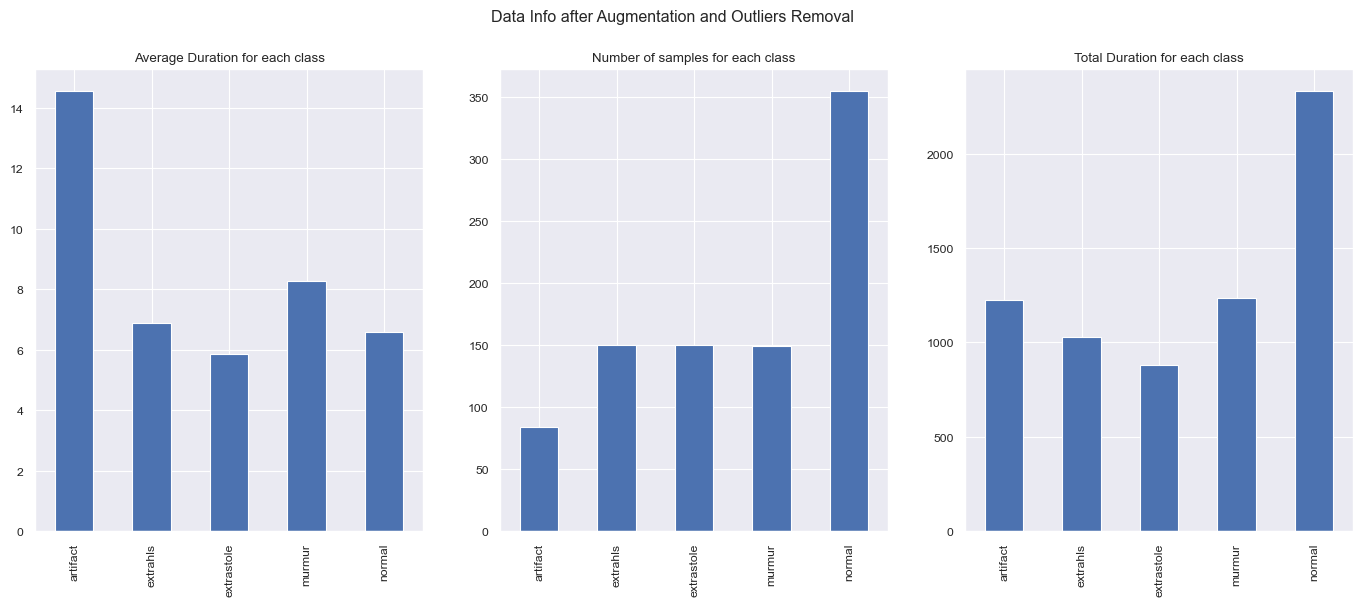

In [26]:
# check the number of samples for each class
nums = {}
for dir in DIRS:
    nums[dir.split('/')[-2][:-1]] = len(os.listdir(dir))
nums['extrahls'] = nums.pop('extrahl')

new_audio_info = pd.DataFrame(avg_duration)
new_audio_info['avg_duration'] = new_audio_info['duration']
new_audio_info.drop('duration', axis=1, inplace=True)
new_audio_info['nums'] = nums
new_audio_info['total_duration'] = new_audio_info['avg_duration'] * new_audio_info['nums']

fig, axs = plt.subplots(1, 3, figsize=(17, 6))
fig.suptitle('Data Info after Augmentation and Outliers Removal')

# avg duraton for each class
new_audio_info['avg_duration'].plot.bar(ax = axs[0], title='Average Duration for each class')
_ = axs[0].set_xlabel('')
_ = axs[0].set_ylabel('')

# number of samples for each class
new_audio_info['nums'].plot.bar(ax = axs[1], title='Number of samples for each class')
_ = axs[1].set_xlabel('')
_ = axs[1].set_ylabel('')

# total duration for each class
new_audio_info['total_duration'].plot.bar(ax = axs[2], title='Total Duration for each class')
_ = axs[2].set_xlabel('')
_ = axs[2].set_ylabel('')